init

In [1]:

import snappy
from snappy import HashMap

jpy = snappy.jpy
from snappy import ProductIO, File
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import numpy as np
import rasterio

from rasterio.enums import Resampling

In [6]:
raster = rasterio.open('./tif/reprojectedSubset.tif')

# This will print out a short version of the  meta data associated with this file.
print(raster.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 65, 'height': 45, 'count': 133, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.011093540833333334, 0.0, 14.055383749166667,
       0.0, -0.011093540833333334, 36.178550630833335)}


Data visualization units.

In [7]:
# Data visualization units.
#unit = '[ K ]'
unit = '[ °C ]'

long_name = 'Sentinel-3 Land Surface Temperature'

# We need to know the geographical extent of the data, this is contained in the raster object.

bbox = raster.bounds
extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
#extent=[35.7, 36.1, 14.1, 14.6]
print (bbox)

BoundingBox(left=14.055383749166667, bottom=35.67934129333334, right=14.776463903333333, top=36.178550630833335)


In [8]:
upscale_factor = 1

# resample data to target shape
data = raster.read(
out_shape=(
    raster.count,
    int(raster.height * upscale_factor),
    int(raster.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
transform = raster.transform * raster.transform.scale(
(raster.width / data.shape[-1]),
(raster.height / data.shape[-2]))

print('Rescaled size: ',np.shape(data[0,:,:]))

Rescaled size:  (45, 65)


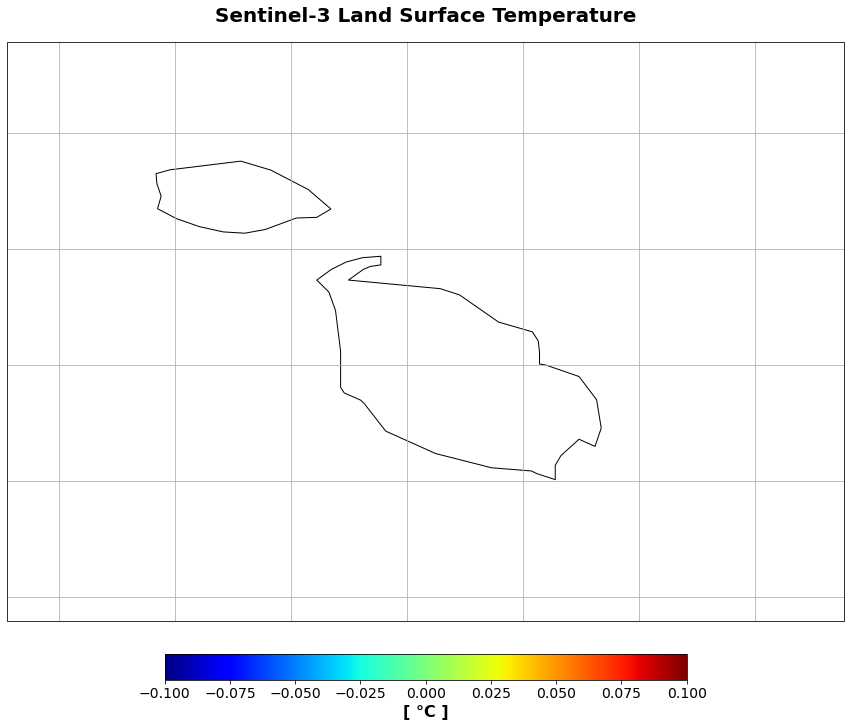

In [9]:
# Here we set up the parameters needed to display the geographical data correctly.
fig=plt.figure(figsize=(15, 12))

# Here we set up a simple Plate Carree geographical projection. This is handled by the Cartopy library.
#proj = ccrs.epsg(3857)
#ax = plt.axes(projection=proj)
ax = plt.axes(projection=ccrs.PlateCarree())

# The coastline data get downloaded here, there may be a delay the first time you run this notebook.
ax.coastlines(resolution='10m')
ax.gridlines()
ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')

# Here we set the colour map for matplotlib. e.g. 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'jet', also
# selecting which colour to associate with the NODATA value in the map

color = cm.jet

color.set_bad('white')

#The pixel associated to the NODATA values are masked out.

data = data.astype(np.float16)
data[data == -32768.0] = np.nan

# As the product contains the data in Digital Numbers (DN), it is necessary to calibrate them with the SCALE FACTOR and OFFSET values.
# These can be retrieved from the extended metadata of the file. 

scale_factor = 0.0020000001

offset = 290

#cal_data = scale_factor * data - 273 + offset
cal_data = data - 273 + offset

img = plt.imshow(cal_data[0,:,:], cmap = color,extent = extent,transform=ccrs.PlateCarree())

cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.05)
cbar.set_label(unit, fontsize=16, fontweight = 'bold')
cbar.ax.tick_params(labelsize=14)
plt.savefig('lst_cropped_snap.png')
plt.show()